In [1]:
# Figure S5

In [2]:
import cartopy.crs as ccrs
import cmaps
from gcpy import single_panel
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import regionmask
from scipy import stats
import seaborn as sns
import xarray as xr

from src import tools

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Original simulations (same function as in Fig1)
variable = "SpeciesConc_O3"
ref = tools.get_original_values_diff(variable, "all_ref_c48", "all_refSNOx_c48", conversion_factor=1e9, resolution='c48')
refshort = tools.get_original_values_diff(variable, "all_polshort_c48", "all_polSNOxshort_c48", conversion_factor=1e9, resolution='c48')

/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:


In [4]:
# Part 1: Regional-mean dO3dENOx
comparison_months = [4,5,6,7,8]
calculate_mean = lambda da: da.sel(time=da.time.dt.month.isin(comparison_months)).resample(time='1Y').mean()
ref_mean = calculate_mean(ref)
refshort_mean = calculate_mean(refshort)

/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:


In [5]:
# Part 2: Grid-box days

# Original simulations
variable = "SpeciesConc_O3"
ref_ratio = tools.get_original_values_ratio(variable, "all_ref_c48", "all_refSNOx_c48", resolution='c48')
refshort_ratio = tools.get_original_values_ratio(variable, "all_refshort_c48", "all_refSNOxshort_c48", resolution='c48')

In [6]:
def get_global_percent_days(months, present_ratio, future_ratio):
    def process_ratio(ratio, months):

        """Selects months, crops to region, removes 'region' dim, and compute total days."""
        ratio = ratio.sel(time=ratio.time.dt.month.isin(months))
        
        if "region" in ratio.dims:
            ratio = ratio.isel(region=0)

        total_days = ratio.resample(time='1Y').count(dim=['time'])
        mean_total_days = total_days.where(total_days > 1).mean(dim=['time', 'sim'])
        
        disbn_days = ratio.where(ratio > 1).resample(time='1Y').count(dim=['time'])
        mean_disbn_days = disbn_days.where(total_days > 1).mean(dim=['time','sim'])
        
        return mean_total_days, mean_disbn_days

    # Process present and future data
    mean_total_present_days, mean_present_disbn_days = process_ratio(present_ratio, months)
    mean_total_future_days, mean_future_disbn_days = process_ratio(future_ratio, months)

    # Compute percentage of disbenefit days
    present_disbn_days_percent = (mean_present_disbn_days / mean_total_present_days)*100
    future_disbn_days_percent = (mean_future_disbn_days / mean_total_future_days)*100

    return present_disbn_days_percent, future_disbn_days_percent


In [7]:
# Part 2: % of O3 disbenefit days
comparison_months = [4,5,6,7,8]
present, future = get_global_percent_days(comparison_months, ref_ratio, refshort_ratio)

/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:


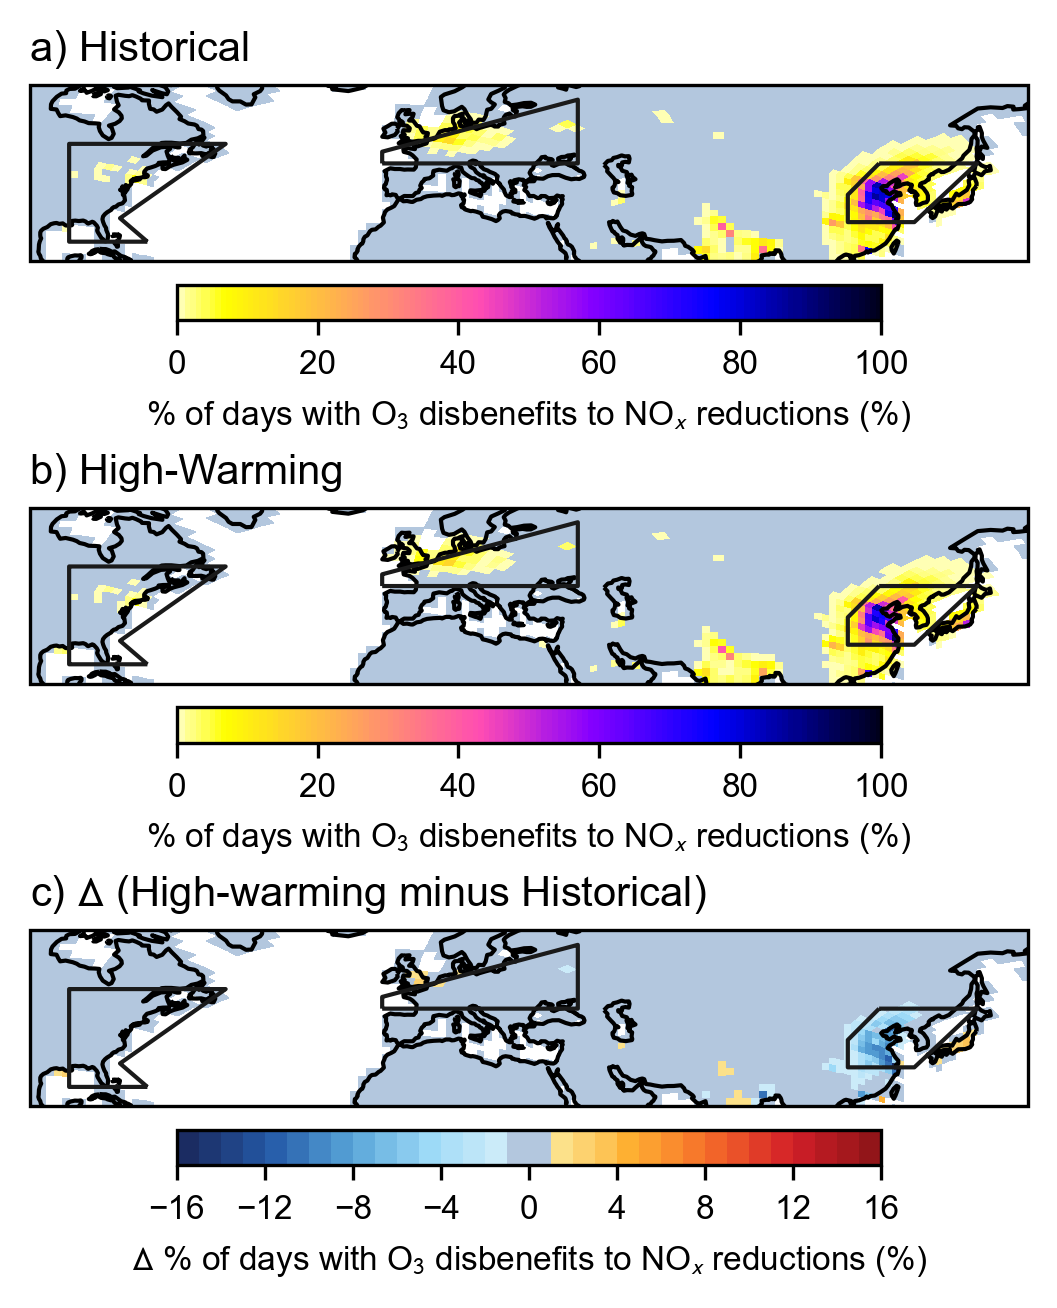

In [8]:
tools.set_matplotlib_font("Arial")

mpl.rcParams.update({
    'axes.edgecolor': 'black',      
    'xtick.color': 'black',         
    'ytick.color': 'black',         
    'xtick.labelcolor': 'black',    
    'ytick.labelcolor': 'black',    
    'grid.color': 'black',          
    'axes.labelcolor': 'black',     
    'axes.titlecolor': 'black',
    'font.size': 10, 
    'axes.titlesize': 10, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 10
})

fig = plt.figure(figsize=(4, 4.5), dpi=300)
gs1 = GridSpec(3, 1, top=0.95, bottom=0.15, left=0.05, right=0.95, hspace=0.8, wspace=0.3)
ax1 = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax2 = fig.add_subplot(gs1[1, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax3 = fig.add_subplot(gs1[2, 0], projection=ccrs.PlateCarree(central_longitude=0))

##########
# CUSTOM COLORMAP 1 (Parts a and b)

# Load base colormap & adjust to remove very light/very dark 
base_cmap = cmaps.MPL_gnuplot2_r
trim_start = 0.025  
trim_end = 0.975   
new_base_colors = base_cmap(np.linspace(trim_start, trim_end, 256))

# Define grey color explicitly for values <= 0
grey_color = (0.7, 0.78, 0.87, 1)  # Medium grey

# Create a new colormap: grey for values ≤ 0, rest use modified base colormap
new_cmap = mcolors.ListedColormap([grey_color] + list(new_base_colors))

#################################
# Part 1. Historical spatial distribution of disbenefit days
ax = ax1

single_panel(plot_vals=present, 
                gridtype="cs",
                ax=ax, 
                comap=new_cmap,
                extent=(-100, 155, 20, 65), 
                vmin=0, vmax=100,
                unit="% of days with O$_3$ disbenefits to NO$_x$ reductions (%)",
                title=None,
                add_cb=True,
                )
ax.coastlines(resolution='110m')
ax.set_title("a) Historical", loc="left")

#################################
# Part 2. High-warming spatial distribution of disbenefit days
ax = ax2

single_panel(plot_vals=future, 
                gridtype="cs",
                ax=ax, 
                comap=new_cmap,
                extent=(-100, 155, 20, 65), 
                vmin=0, vmax=100,
                unit="% of days with O$_3$ disbenefits to NO$_x$ reductions (%)",
                title=None,
                add_cb=True,
                )
ax.coastlines(resolution='110m')
ax.set_title("b) High-Warming", loc="left")

#############
# CUSTOM COLORMAP 2 (Part c)

# Load base colormap
base_cmap = cmaps.BlueWhiteOrangeRed
# Extract first 10 values (deep blues) and last 10 values (deep reds)
blues = base_cmap(np.linspace(0, 0.35, 15)) # blues
reds = base_cmap(np.linspace(0.65, 1.0, 15)) # reds

# Create new colormap with grey colors for changes less than +/- 1%
custom_colors = np.vstack((blues, [grey_color, grey_color], reds))
custom_cmap = mcolors.ListedColormap(custom_colors)
levels = np.arange(-16, 17, 1)
norm = mcolors.BoundaryNorm(levels, custom_cmap.N)

#################################
# Part 3. Change between High-warming and Historical (High-warming minus Historical)
ax = ax3 

single_panel(plot_vals=(future-present), 
                gridtype="cs",
                ax=ax, 
                comap=custom_cmap,
                norm=norm,
                extent=(-100, 155, 20, 65), 
                vmin=-17, vmax=17,
                unit="$\Delta$ % of days with O$_3$ disbenefits to NO$_x$ reductions (%)",
                title=None,
                add_cb=True,
                )
ax.coastlines(resolution='110m')
ax.set_title("c) $\Delta$ (High-warming minus Historical)", loc="left")

# Add boxes around the IPCC AR6 regions
for ax in [ax1, ax2, ax3]:
    ar6 = regionmask.defined_regions.ar6.all
    ar6[5,17].plot_regions(
        ax=ax,
            add_label=False,
            line_kws=dict(lw=1),
        )

    # For EAS we use a modified polygon that captures a more homogeneous response
    new_EAS = np.array([[117,45], [109,37], [109,30], [126,30],[142,45]])
    new_EAS_region = regionmask.Regions([new_EAS], name="new_EAS")
    new_EAS_region.plot_regions(add_label=False, ax=ax, line_kws=dict(lw=1))

plt.savefig("FigS5_new.png")    

In [9]:
ar6_region = {"ENA": 5, "EAS": 58, "WCE": 17}
region = "EAS"
present_EAS = tools.crop_regionmask_ar6_c48(present, region_num=ar6_region[region])
future_EAS = tools.crop_regionmask_ar6_c48(future, region_num=ar6_region[region])
change_EAS = tools.crop_regionmask_ar6_c48(future-present, region_num=ar6_region[region])
pctchange_EAS = tools.crop_regionmask_ar6_c48(((future-present)/present)*100, region_num=ar6_region[region])

In [ ]:
# Print gridbox-level min/max percent change for NEA (="EAS") - not reported
print(present_EAS.max().values)
print(present_EAS.min().values)

print(future_EAS.max().values)
print(future_EAS.min().values)

print(change_EAS.max().values)
print(change_EAS.min().values)

97.04248366013071
1.1683006535947713
93.0392156862745
1.2581699346405228
1.0457516339869315
-15.931372549019606
